In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "/Users/wangze/dddd/input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.
df = pd.read_csv("/Users/wangze/dddd/input/data.csv")
df.info()


data.csv
sample_submission.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null float64
game_id               30697 non-null float64
lat                   30697 non-null float64
loc_x                 30697 non-null float64
loc_y                 30697 non-null float64
lon                   30697 non-null float64
minutes_remaining     30697 non-null float64
period                30697 non-null float64
playoffs              30697 non-null float64
season                30697 non-null object
seconds_remaining     30697 non-null float64
shot_distance         1048575 non-null object
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_i

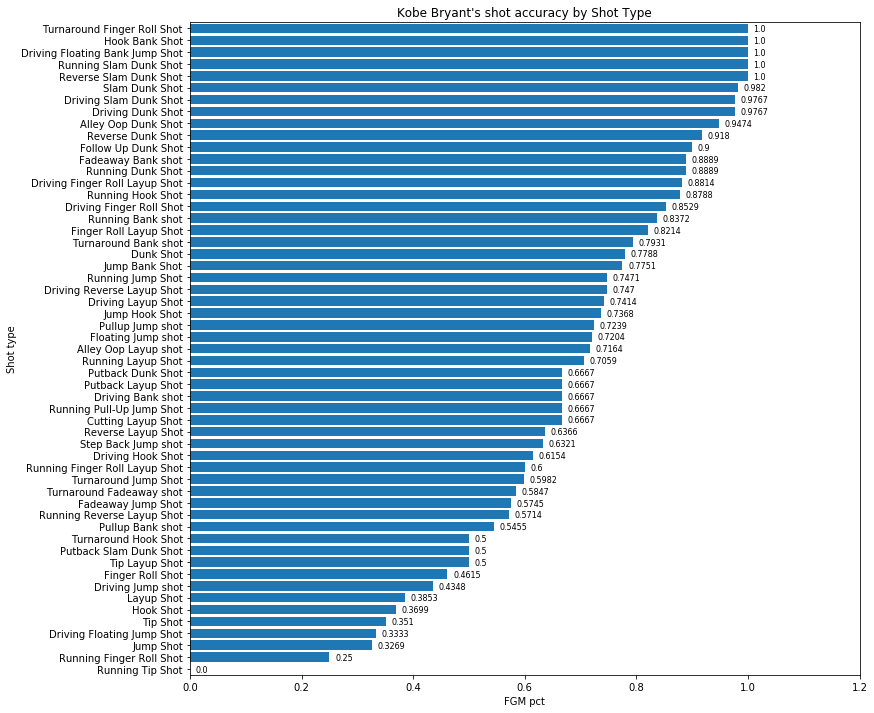

In [3]:
#Let's look at action_type. We suspect it will give a good indication about the difficulty of the shot
df_action = df.dropna()[['action_type','shot_made_flag']].groupby(['action_type']).mean().sort_values(by='shot_made_flag',ascending=1)
plt.figure(figsize=(12,12))
barpos = np.arange(len(df_action.index))+.5
plt.barh(barpos,df_action['shot_made_flag'],align='center')
plt.yticks(barpos, df_action.index)
for i, v in enumerate(df_action['shot_made_flag']):
    plt.text(v + 0.01, i + .25, str(round(v,4)), fontsize=8)
plt.xlim(0,1.2)
plt.ylim(0,len(df_action.index)) #set row limit
plt.title('Kobe Bryant\'s shot accuracy by Shot Type')
plt.xlabel('FGM pct')
plt.ylabel('Shot type')
plt.show()
plt.savefig('Kobe Bryants shot accuracy by Shot Type.png')

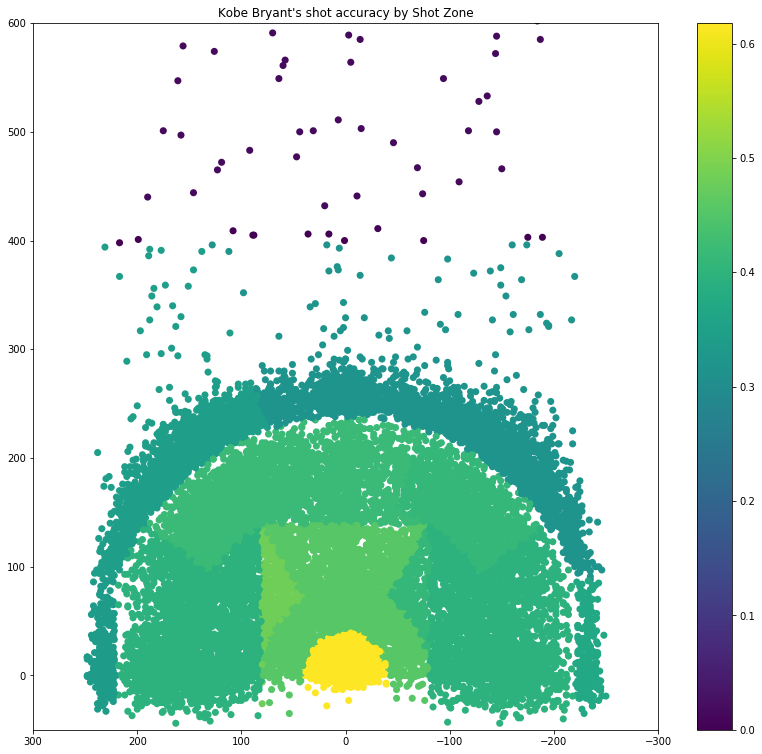

In [4]:
#As expected dunks and close to the basket type shots are close to 100%. Interestingly
#Jump Shot percentage is only 32.69% which is very low but it's very likely that it includes a lot of 
#3pt shots and perhaps end of quarter half-court shots so it should be low.
#We can also see that Kobe Bryant's signature Fadeaway Jump Shots are quite high given the difficulty 
#of those shots. (around 58%)

#Let's now look at the shot chart by zone. We will use shot_zone_area combined with shot_zone_basic 
#to map the location of the shot.
df_temp = df[['loc_x','loc_y','shot_made_flag']].dropna()
df_temp['shot_zone_combined'] = df[['shot_zone_area','shot_zone_basic']].apply(lambda x: ''.join(x), axis=1)
shot_zone_map = df_temp.groupby(['shot_zone_combined']).mean()['shot_made_flag']
df_temp['avg_by_shot_zone_combined'] = df_temp['shot_zone_combined'].map(shot_zone_map)
fig = plt.figure(figsize=(14,13))
plt.scatter(df_temp['loc_x'],df_temp['loc_y'],c=df_temp['avg_by_shot_zone_combined'],s=50, cmap='viridis',edgecolors='none')
plt.xlim(300,-300)
plt.ylim(-50,600)
plt.colorbar()
plt.title('Kobe Bryant\'s shot accuracy by Shot Zone')
plt.show()
plt.savefig('Kobe Bryants shot accuracy by zone.png')

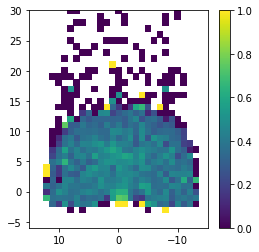

In [5]:
#As we can see Kobe is slightly better from the right side of the basket. Let's try a bit more granularity
#using just loc_x and loc_y
df['loc_x_bucket'] = df['loc_x']//20
df['loc_y_bucket'] = df['loc_y']//20
df_temp = df[['loc_x','loc_y','loc_x_bucket','loc_y_bucket','shot_made_flag']].dropna()
shot_pos_map = df_temp.groupby(['loc_x_bucket','loc_y_bucket']).mean()['shot_made_flag']
df_shots = shot_pos_map.reset_index(level=['loc_x_bucket','loc_y_bucket']).dropna()
#df_shots.head(20)
fig = plt.figure(figsize=(4,4))
plt.scatter(df_shots['loc_x_bucket'],df_shots['loc_y_bucket'],c=df_shots['shot_made_flag'],s=45, cmap='viridis',edgecolors='none', marker='s')
plt.xlim(15,-15)
plt.ylim(-6,30)
plt.colorbar()
plt.show()
plt.savefig('Kobe Bryants shot accuracy by location.png')

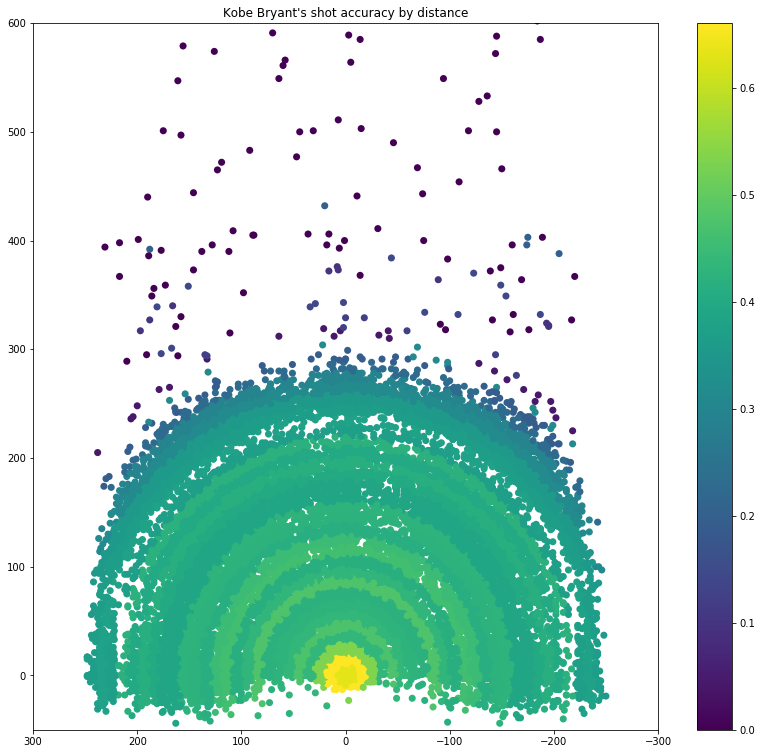

In [6]:
#As we can see the shot chart is not uniform from similar distance and Kobe might have some sweet-spots.
#However some of those yellow zones might be cause by low sample (e.g. very long 3pt shot from center court)

#Let's look at a similar chart by distance
df_temp = df[['loc_x','loc_y','shot_distance','shot_made_flag']].dropna()
shot_distance_map = df_temp.groupby(['shot_distance']).mean()['shot_made_flag']
df_temp['avg_by_shot_distance'] = df_temp['shot_distance'].map(shot_distance_map)
#df_temp.head(20)
fig = plt.figure(figsize=(14,13))
plt.scatter(df_temp['loc_x'],df_temp['loc_y'],c=df_temp['avg_by_shot_distance'],s=50, cmap='viridis',edgecolors='none')
plt.xlim(300,-300)
plt.ylim(-50,600)
plt.title('Kobe Bryant\'s shot accuracy by distance')
plt.colorbar()
plt.savefig('Kobe Bryants shot accuracy by distnace.png')

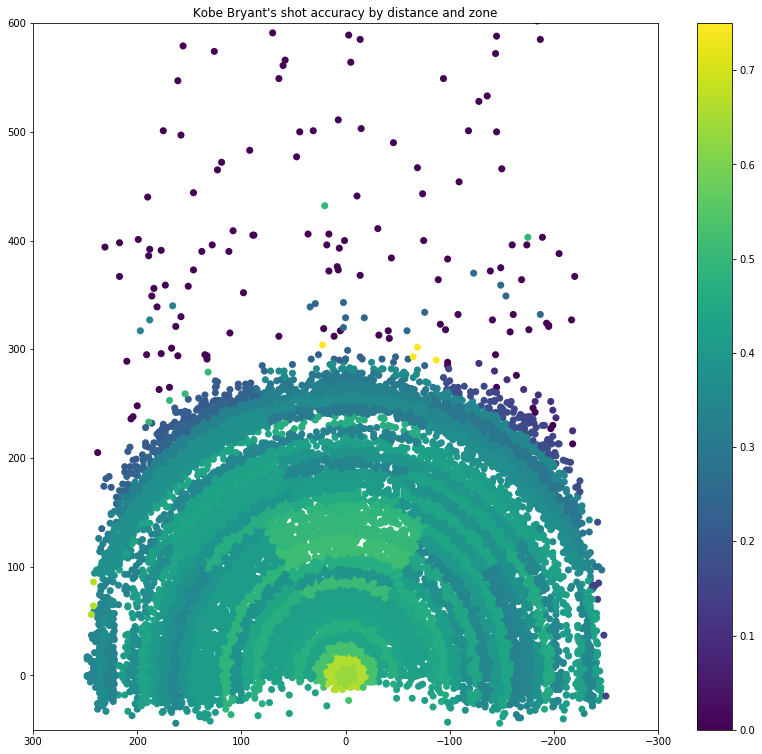

In [7]:
#We can clearly see that there are some bands where the accuracy is higher even from longer distances.
#I actually expected a smooth decline in accuracy with distance

#Let's add shot_zone_area to the mix to have create even nicer shot zones, and look at left vs center vs right
#Let's look at a similar chart by distance
df_temp = df[['loc_x','loc_y','shot_distance','shot_zone_area','shot_made_flag']].dropna()
#df_temp['shot_zone_dist_combined'] = df[['shot_zone_area','shot_distance']].apply(lambda x: ''.join(x), axis=1)
shot_zone_map = df_temp.groupby(['shot_distance','shot_zone_area']).mean()['shot_made_flag']
df_shots = shot_zone_map.reset_index(level=['shot_distance','shot_zone_area']).dropna()
df_shots = df_shots.rename(columns={'shot_made_flag': 'shot_acc'})
df_temp = pd.merge(df_temp,df_shots,how="left",on=['shot_distance','shot_zone_area'])
fig = plt.figure(figsize=(14,13))
plt.scatter(df_temp['loc_x'],df_temp['loc_y'],c=df_temp['shot_acc'],s=50, cmap='viridis',edgecolors='none')
plt.xlim(300,-300)
plt.ylim(-50,600)
plt.title('Kobe Bryant\'s shot accuracy by distance and zone')
plt.colorbar()
plt.savefig('Kobe Bryants shot accuracy by distnace2.png')

In [3]:
#It looks like Kobe (apart from the obvious close to the basket shots) is best from spots around foul line
#Looking at 3-pointers however we can clearly see that he feels better from wings.
#Also right side looks a bit better than the left, which is expected as he is right handed.

#So Let's see how well we will do using just the percentage predictions from action_type
import pandas as pd 
df = pd.read_csv("/Users/wangze/dddd/input/data.csv")

df_temp = df[['action_type','shot_made_flag']].dropna()
df_shot_acc = df_temp.groupby(['action_type']).mean()['shot_made_flag']
df_shot_acc = df_shot_acc.reset_index(level=['action_type']).dropna()
#drop-back for missing preditions
df_temp = df[['shot_distance','shot_zone_area','shot_made_flag']].dropna()
df_shot_acc2 = df_temp.groupby(['shot_distance','shot_zone_area']).mean()['shot_made_flag']
df_shot_acc2 = df_shot_acc2.reset_index(level=['shot_distance','shot_zone_area']).dropna()

df_predict = df[['action_type','shot_made_flag','shot_distance','shot_zone_area','shot_id']][df['shot_made_flag'].isnull()]
df_predict = pd.merge(df_predict,df_shot_acc,how="left",on=['action_type'])
#check for missing predictions
nulls = df_predict[df_predict['shot_made_flag_y'].isnull()]
nulls = pd.merge(nulls,df_shot_acc2,how="left",on=['shot_distance','shot_zone_area'])
nulls = nulls[['shot_id','shot_made_flag']]

submission = df_predict[['shot_id','shot_made_flag_y']]
submission = submission.rename(columns={'shot_made_flag_y': 'shot_made_flag'})
submission = submission[submission['shot_made_flag'].isnull() != True]
submission = pd.concat([submission,nulls])
submission.info()
submission[['shot_id', 'shot_made_flag']].to_csv('submission.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 1
Data columns (total 2 columns):
shot_id           5000 non-null int64
shot_made_flag    5000 non-null float64
dtypes: float64(1), int64(1)
memory usage: 117.2 KB
